# Import Packages and Functions

In [1]:
import hssm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helper_functions import *

# Basics
import os
import sys
import time
from matplotlib import pyplot as plt
import arviz as az  # Visualization
import pytensor  # Graph-based tensor library
import ssms
from ssms.basic_simulators.simulator import simulator
import numpy as np
import pandas as pd
# import ssms.basic_simulators # Model simulators
import hddm_wfpt
import bambi as bmb

from jax import config
config.update("jax_enable_x64", False)

# Setting float precision in pytensor
pytensor.config.floatX = "float32"

/oscar/home/avo2/mambaforge/envs/hssm_gpu2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Set the right model name

MODEL_NAME = 'par'
if MODEL_NAME == 'seq':
    model_onnx_path = '/users/avo2/data/avo2/tsumme_data/seq2_no_bias'
    model_name = 'ddm_seq2_no_bias'
elif MODEL_NAME == 'par':
    model_onnx_path = '/users/avo2/data/avo2/tsumme_data/par2_no_bias'
    model_name = 'ddm_par2_no_bias'
elif MODEL_NAME == 'leak':
    model_onnx_path = '/users/avo2/data/avo2/LANminimal/data/networks/torch/lan/leak_200k_005/leak_200k_005_lan_293732d218be11efa960a0423f3e9b68_torch_model.onnx'
# model_onnx_path = '/users/avo2/data/avo2/tsumme_data/seq2_no_bias'
    model_name = 'ddm_mic2_leak_no_bias_no_lowdim_noise'

In [ ]:
def generate_sanity_dataset():
    """
    Function that generates a hierarchical dataset based on the model specified above. Note that all the stdevs are 0.

    Parameters
    ----------
    None

    Returns
    ----------
    data: a pandas of the generated data as well as all the relevant ground truth values.
    """
        
        group_mu_a = 1.3
        group_sd_a = 0
        group_mu_t = 0.35
        group_sd_t = 0
        n_subj = 35
        n_trial = 512
        subj_mu_a = np.random.normal(loc = group_mu_a, scale = group_sd_a, size = n_subj) 
        subj_mu_a_trialwise = np.repeat(subj_mu_a, n_trial) 
        subj_mu_t = np.random.normal(loc = group_mu_t, scale = group_sd_t, size = n_subj) 
        subj_mu_t_trialwise = np.repeat(subj_mu_t, n_trial) 

        vh_covariate = np.random.choice([-1,1], n_subj * n_trial) #Representing the coherence
        vh_mu = np.random.normal(2, 0) #We set vh_mu high here so that there's no error
        vh_beta = np.random.normal(0.2, 0)
        vh_trialwise = vh_mu + vh_beta * vh_covariate

        vl1_covariate = np.random.choice([-1,1], n_subj * n_trial)
        vl1_mu = np.random.normal(.7, 0)
        vl1_beta = np.random.normal(1.5, 0) #vl1_beta is set high here so there should be noticeable effect of coherence level
        vl1_trialwise = vl1_mu + vl1_beta * vl1_covariate



        # vl2_covariate = np.random.uniform(low = -1,high = 1, size = n_subj * n_trial)
        vl2_covariate = np.random.choice([-1,1], n_subj * n_trial)
        vl2_mu = np.random.normal(.7, 0)
        vl2_beta = np.random.normal(0,0)
        vl2_trialwise = vl2_mu + vl2_beta * vl2_covariate


        #Ground truth to save mu's and beta's in the dataframe
        vh_mu_pd = np.repeat(vh_mu, n_subj*n_trial)
        vl1_mu_pd = np.repeat(vl1_mu, n_subj*n_trial)
        vl2_mu_pd = np.repeat(vl2_mu, n_subj*n_trial)
        vh_beta = np.repeat(vh_beta, n_subj*n_trial)
        vl1_beta = np.repeat(vl1_beta, n_subj*n_trial)
        vl2_beta = np.repeat(vl2_beta, n_subj*n_trial)

        #Generate ground truth pandas
        participant_id = np.repeat(np.arange(n_subj), n_trial).astype(int) 
        data = pd.DataFrame(np.vstack([vh_trialwise, vl1_trialwise, vl2_trialwise, subj_mu_a_trialwise,  subj_mu_t_trialwise, vh_covariate, vl1_covariate, vl2_covariate,
                                vh_mu_pd, vl1_mu_pd, vl2_mu_pd, vh_beta, vl1_beta, vl2_beta, participant_id]).T, 
                        columns = ['vh', 'vl1', 'vl2', 'a', 't', 'highDimCoh', 'lowDimCoh', 'irrDimCoh','vh_mu_pd', 'vl1_mu_pd', 'vl2_mu_pd', 'vh_beta', 'vl1_beta' , 'vl2_beta', 'subj_idx']) 
        data['subj_idx'] = data['subj_idx'].values.astype(int) 

        #Call SSMS
        sim_out = ssms.basic_simulators.simulator.simulator(model = model_name, 
                                                        theta = data[['vh', 'vl1', 'vl2', 'a', 't']], 
                                                        n_samples = 1) 
        data['rt'] = sim_out['rts'].squeeze() 
        data['response'] = sim_out['choices'].squeeze()

        return data

In [7]:
def generate_dataset():

        group_mu_a = 1.55
        group_sd_a = 0.15
        group_mu_t = 0.35
        group_sd_t = .003
        n_subj = 35
        n_trial = 512
        subj_mu_a = np.random.normal(loc = group_mu_a, scale = group_sd_a, size = n_subj) 
        subj_mu_a_trialwise = np.repeat(subj_mu_a, n_trial) 
        subj_mu_t = np.random.normal(loc = group_mu_t, scale = group_sd_t, size = n_subj) 
        subj_mu_t_trialwise = np.repeat(subj_mu_t, n_trial) 

        # vh_covariate = np.random.uniform(low = -1,high = 1, size = n_subj * n_trial) 
        vh_covariate = np.random.choice([-1,1], n_subj * n_trial)
        vh_mu = np.random.normal(1.75, .5)
        vh_beta = np.random.normal(1,.5)
        vh_trialwise = vh_mu + vh_beta * vh_covariate

        # vl1_covariate = np.random.uniform(low = -1,high = 1, size = n_subj * n_trial)
        vl1_covariate = np.random.choice([-1,1], n_subj * n_trial)
        vl1_mu = np.random.normal(2.25, .5)
        vl1_beta = np.random.normal(1.2,.5)
        vl1_trialwise = vl1_mu + vl1_beta * vl1_covariate



        # vl2_covariate = np.random.uniform(low = -1,high = 1, size = n_subj * n_trial)
        vl2_covariate = np.random.choice([-1,1], n_subj * n_trial)
        vl2_mu = np.random.normal(1, .5)
        vl2_beta = np.random.normal(1.2,.5)
        vl2_trialwise = vl2_mu + vl2_beta * vl2_covariate

        vh_mu_pd = np.repeat(vh_mu, n_subj*n_trial)
        vl1_mu_pd = np.repeat(vl1_mu, n_subj*n_trial)
        vl2_mu_pd = np.repeat(vl2_mu, n_subj*n_trial)
        vh_beta = np.repeat(vh_beta, n_subj*n_trial)
        vl1_beta = np.repeat(vl1_beta, n_subj*n_trial)
        vl2_beta = np.repeat(vl2_beta, n_subj*n_trial)


        participant_id = np.repeat(np.arange(n_subj), n_trial).astype(int) 
        data = pd.DataFrame(np.vstack([vh_trialwise, vl1_trialwise, vl2_trialwise, subj_mu_a_trialwise,  subj_mu_t_trialwise, vh_covariate, vl1_covariate, vl2_covariate,
                                vh_mu_pd, vl1_mu_pd, vl2_mu_pd, vh_beta, vl1_beta, vl2_beta, participant_id]).T, 
                        columns = ['vh', 'vl1', 'vl2', 'a', 't', 'highDimCoh', 'lowDimCoh', 'irrDimCoh','vh_mu_pd', 'vl1_mu_pd', 'vl2_mu_pd', 'vh_beta', 'vl1_beta' , 'vl2_beta', 'subj_idx']) 
        data['subj_idx'] = data['subj_idx'].values.astype(int) 
        sim_out = ssms.basic_simulators.simulator.simulator(model = model_name, 
                                                        theta = data[['vh', 'vl1', 'vl2', 'a', 't']], 
                                                        n_samples = 1) 
        data['rt'] = sim_out['rts'].squeeze() 
        data['response'] = sim_out['choices'].squeeze()

        return data

[0.         0.         0.         0.0010989  0.00119048]
[0.00660608 0.00894308 0.00780762 0.00662957 0.00445264]
[0.14345415 0.14200323 0.14081066 0.13321043 0.13416824]
[0.00660608 0.00894308 0.00780762 0.00662957 0.00445264]
[0.02237302 0.01671345 0.01474368 0.00534013 0.00119048]
[0.00114286 0.         0.         0.         0.        ]
[0.14918841 0.1253334  0.14293434 0.12678368 0.1492518 ]
[0.00114286 0.         0.         0.         0.        ]
[0.         0.         0.         0.         0.00136054]
[0.00114286 0.00098522 0.00124224 0.00114286 0.00477019]
[0.12431027 0.13387797 0.12637689 0.12624948 0.11970965]
[0.00114286 0.00098522 0.00124224 0.00114286 0.00477019]
[0.0053792  0.0045422  0.00119048 0.00095238 0.00095238]
[0. 0. 0. 0. 0.]
[0.1513344  0.13648345 0.13725661 0.13518215 0.13941376]
[0. 0. 0. 0. 0.]
0.006224988883948421
0.001456745853877185


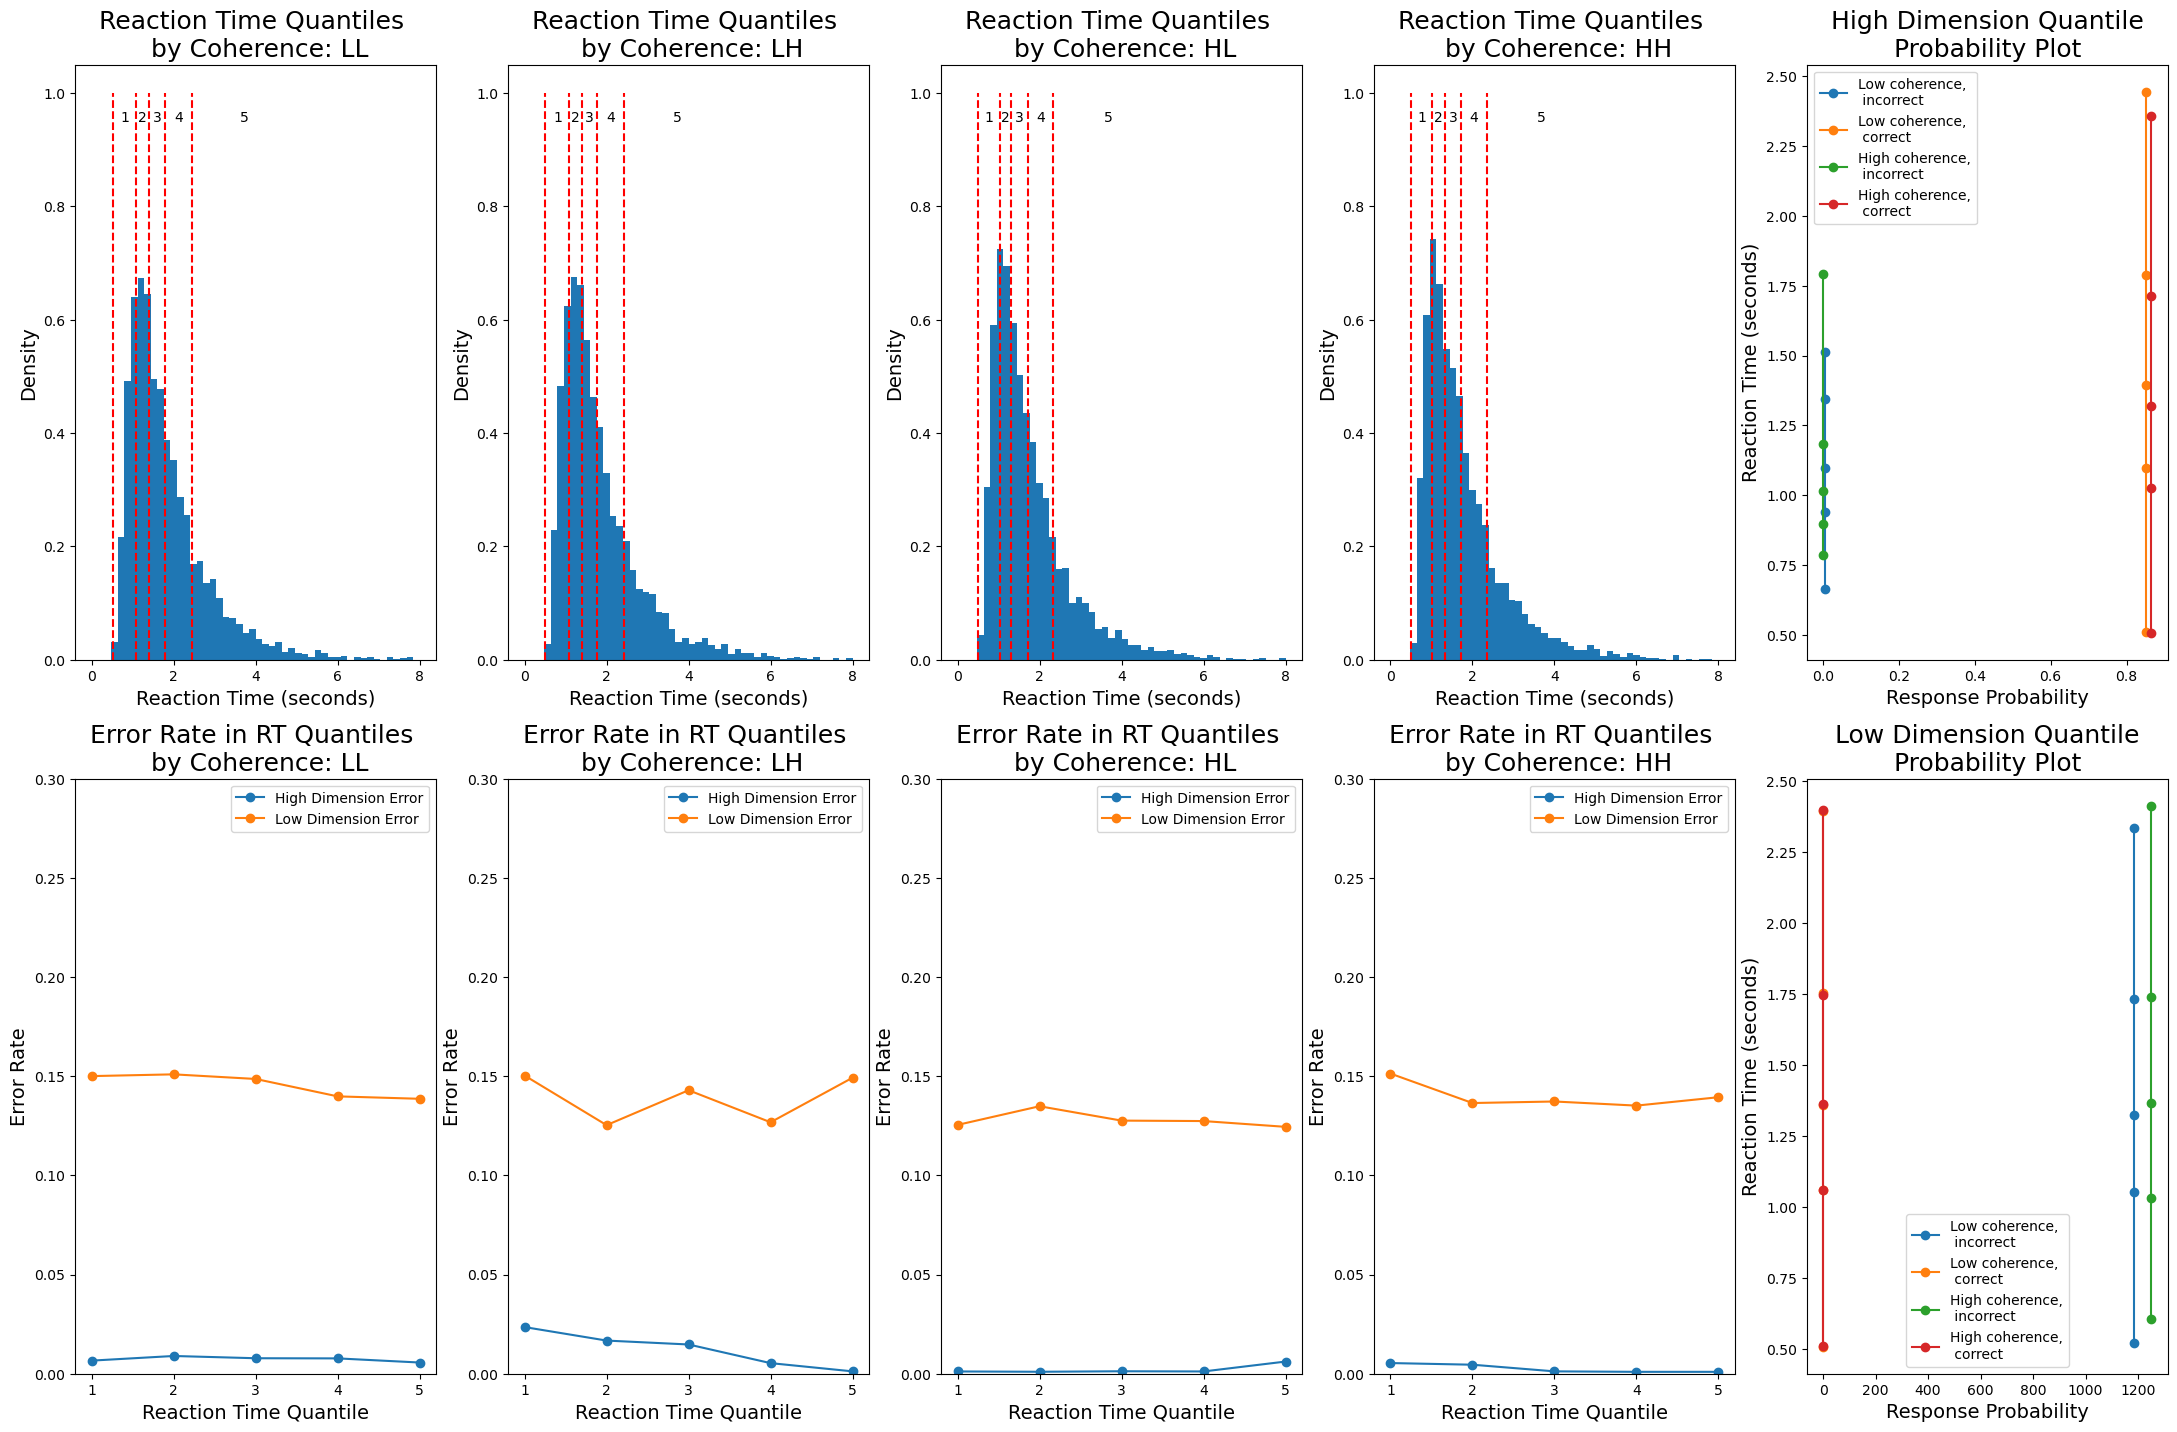

In [4]:
#Generate the data and plot the relevant plots
data = generate_sanity_dataset()
#Edit into form that the code wants
data = data.rename({'rt': 'rxtime',
                    'subj_idx': 'subj'}, axis = 'columns')

plt.figure(figsize=(27,17))
all_plots(data)


In [ ]:
##Chong data coding: High Dim : low coherence, incorrect = 1; correct = 3
                #    Low Ddim : low coherence, incorrect = 2; correct = 3

                
                #  (high/low) 0: wrong, wrong; 1: wrong, right; right, wrong; Right Right

In [22]:
high_coh = data[data['highDimCoh'] == 1]

In [58]:
lowDim_high_coh = data[data['lowDimCoh'] == 1]
lowDim_low_coh = data[data['lowDimCoh'] == -1]

In [62]:
lowDim_low_coh[lowDim_low_coh['response'] == 2]

,vh,vl1,vl2,a,t,highDimCoh,lowDimCoh,irrDimCoh,vh_mu_pd,vl1_mu_pd,vl2_mu_pd,vh_beta,vl1_beta,vl2_beta,subj,rxtime,response
95,1.85,0.75,1.45,1.3,0.35,1.0,-1.0,-1.0,1.55,1.75,1.75,0.3,1.0,0.3,0,2.016561,2
119,1.85,0.75,1.45,1.3,0.35,1.0,-1.0,-1.0,1.55,1.75,1.75,0.3,1.0,0.3,0,2.092567,2
168,1.25,0.75,1.45,1.3,0.35,-1.0,-1.0,-1.0,1.55,1.75,1.75,0.3,1.0,0.3,0,3.278427,2
657,1.85,0.75,1.45,1.3,0.35,1.0,-1.0,-1.0,1.55,1.75,1.75,0.3,1.0,0.3,1,1.175342,2
1212,1.25,0.75,2.05,1.3,0.35,-1.0,-1.0,1.0,1.55,1.75,1.75,0.3,1.0,0.3,2,0.993352,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17151,1.25,0.75,1.45,1.3,0.35,-1.0,-1.0,-1.0,1.55,1.75,1.75,0.3,1.0,0.3,33,1.562579,2
17246,1.25,0.75,1.45,1.3,0.35,-1.0,-1.0,-1.0,1.55,1.75,1.75,0.3,1.0,0.3,33,1.500180,2
17282,1.25,0.75,1.45,1.3,0.35,-1.0,-1.0,-1.0,1.55,1.75,1.75,0.3,1.0,0.3,33,1.176098,2
17527,1.85,0.75,2.05,1.3,0.35,1.0,-1.0,1.0,1.55,1.75,1.75,0.3,1.0,0.3,34,2.187701,2


In [61]:
lowDim_high_coh[lowDim_high_coh['response'] == 2]

,vh,vl1,vl2,a,t,highDimCoh,lowDimCoh,irrDimCoh,vh_mu_pd,vl1_mu_pd,vl2_mu_pd,vh_beta,vl1_beta,vl2_beta,subj,rxtime,response
180,1.85,2.75,1.45,1.3,0.35,1.0,1.0,-1.0,1.55,1.75,1.75,0.3,1.0,0.3,0,2.147310,2
211,1.25,2.75,1.45,1.3,0.35,-1.0,1.0,-1.0,1.55,1.75,1.75,0.3,1.0,0.3,0,3.027764,2
304,1.25,2.75,1.45,1.3,0.35,-1.0,1.0,-1.0,1.55,1.75,1.75,0.3,1.0,0.3,0,1.541164,2
653,1.85,2.75,1.45,1.3,0.35,1.0,1.0,-1.0,1.55,1.75,1.75,0.3,1.0,0.3,1,1.083439,2
669,1.85,2.75,2.05,1.3,0.35,1.0,1.0,1.0,1.55,1.75,1.75,0.3,1.0,0.3,1,1.306606,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16534,1.85,2.75,1.45,1.3,0.35,1.0,1.0,-1.0,1.55,1.75,1.75,0.3,1.0,0.3,32,3.143619,2
16727,1.85,2.75,1.45,1.3,0.35,1.0,1.0,-1.0,1.55,1.75,1.75,0.3,1.0,0.3,32,2.051428,2
17136,1.25,2.75,1.45,1.3,0.35,-1.0,1.0,-1.0,1.55,1.75,1.75,0.3,1.0,0.3,33,2.265517,2
17177,1.85,2.75,1.45,1.3,0.35,1.0,1.0,-1.0,1.55,1.75,1.75,0.3,1.0,0.3,33,1.924145,2


In [39]:
np.unique(data['response'], return_counts = True)

(array([0, 1, 2, 3], dtype=int32), array([    6,   380,   214, 17320]))

In [26]:
np.unique(low_coh['response'], return_counts = True)

(array([0, 1, 2, 3], dtype=int32), array([7103, 1085,  806,   25]))

In [29]:
chong_data = data

In [31]:
high_low = chong_data[(chong_data['highDimCoh']==1) & (chong_data['lowDimCoh']==-1)]
rate_by_quantile(high_low,2,5)

array([0.01348186, 0.00332085, 0.01904592, 0.01209426, 0.02180511])

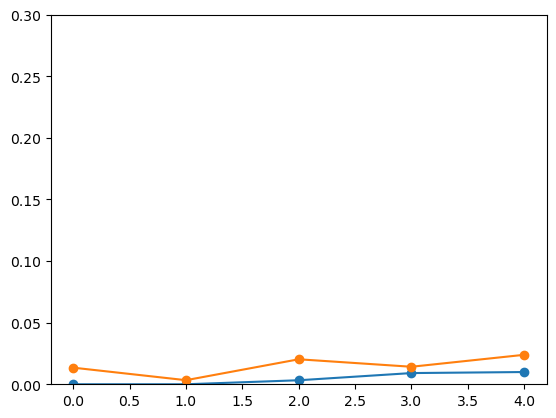

In [32]:
err_plot(chong_data[(chong_data['highDimCoh']==1) & (chong_data['lowDimCoh']==-1)],5)

In [78]:
low_low = chong_data[(chong_data['highDimCoh']==-1) & (chong_data['lowDimCoh']==-1)]

In [83]:
low_low[low_low['response'] == 0]

,vh,vl1,vl2,a,t,highDimCoh,lowDimCoh,irrDimCoh,vh_mu_pd,vl1_mu_pd,vl2_mu_pd,vh_beta,vl1_beta,vl2_beta,subj,rxtime,response
5878,0.208188,2.319803,2.545624,1.710337,0.3536,-1.0,-1.0,1.0,1.176405,2.9144,1.85327,0.968217,0.594597,0.692354,11,2.005124,0


In [41]:
data

,vh,vl1,vl2,a,t,highDimCoh,lowDimCoh,irrDimCoh,vh_mu_pd,vl1_mu_pd,vl2_mu_pd,vh_beta,vl1_beta,vl2_beta,subj,rxtime,response
0,0.75,0.25,3.25,1.3,0.35,-1.0,-1.0,1.0,1.75,1.75,1.75,1.0,1.5,1.5,0,5.004700,3
1,0.75,0.25,3.25,1.3,0.35,-1.0,-1.0,1.0,1.75,1.75,1.75,1.0,1.5,1.5,0,2.833848,3
2,0.75,0.25,0.25,1.3,0.35,-1.0,-1.0,-1.0,1.75,1.75,1.75,1.0,1.5,1.5,0,2.263133,2
3,0.75,0.25,3.25,1.3,0.35,-1.0,-1.0,1.0,1.75,1.75,1.75,1.0,1.5,1.5,0,4.254247,1
4,0.75,0.25,0.25,1.3,0.35,-1.0,-1.0,-1.0,1.75,1.75,1.75,1.0,1.5,1.5,0,1.592631,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17915,2.75,0.25,3.25,1.3,0.35,1.0,-1.0,1.0,1.75,1.75,1.75,1.0,1.5,1.5,34,0.911226,3
17916,0.75,0.25,3.25,1.3,0.35,-1.0,-1.0,1.0,1.75,1.75,1.75,1.0,1.5,1.5,34,1.376460,3
17917,0.75,3.25,0.25,1.3,0.35,-1.0,1.0,-1.0,1.75,1.75,1.75,1.0,1.5,1.5,34,2.945345,3
17918,0.75,3.25,0.25,1.3,0.35,-1.0,1.0,-1.0,1.75,1.75,1.75,1.0,1.5,1.5,34,2.838780,3


[0.0564301  0.08892502 0.10145575 0.13491063 0.1340952 ]
[0.01620853 0.00996349 0.0189479  0.01464761 0.0231503 ]
[0.03955242 0.04386322 0.07066247 0.06080738 0.0839649 ]
[0.01620853 0.00996349 0.0189479  0.01464761 0.0231503 ]
[0.17189111 0.14124774 0.11699821 0.11096227 0.07549011]
[0. 0. 0. 0. 0.]
[0.03019064 0.04198825 0.05069623 0.05537001 0.07861675]
[0. 0. 0. 0. 0.]
[0.         0.         0.00208412 0.         0.00241875]
[0. 0. 0. 0. 0.]
[0.01915831 0.03550999 0.04731158 0.06630843 0.12140774]
[0. 0. 0. 0. 0.]
[0.00102041 0.         0.00211931 0.0010989  0.        ]
[0. 0. 0. 0. 0.]
[0.02701902 0.03795965 0.04466448 0.09239271 0.10625579]
[0. 0. 0. 0. 0.]
0.1134305279434504
0.0009023234829686443


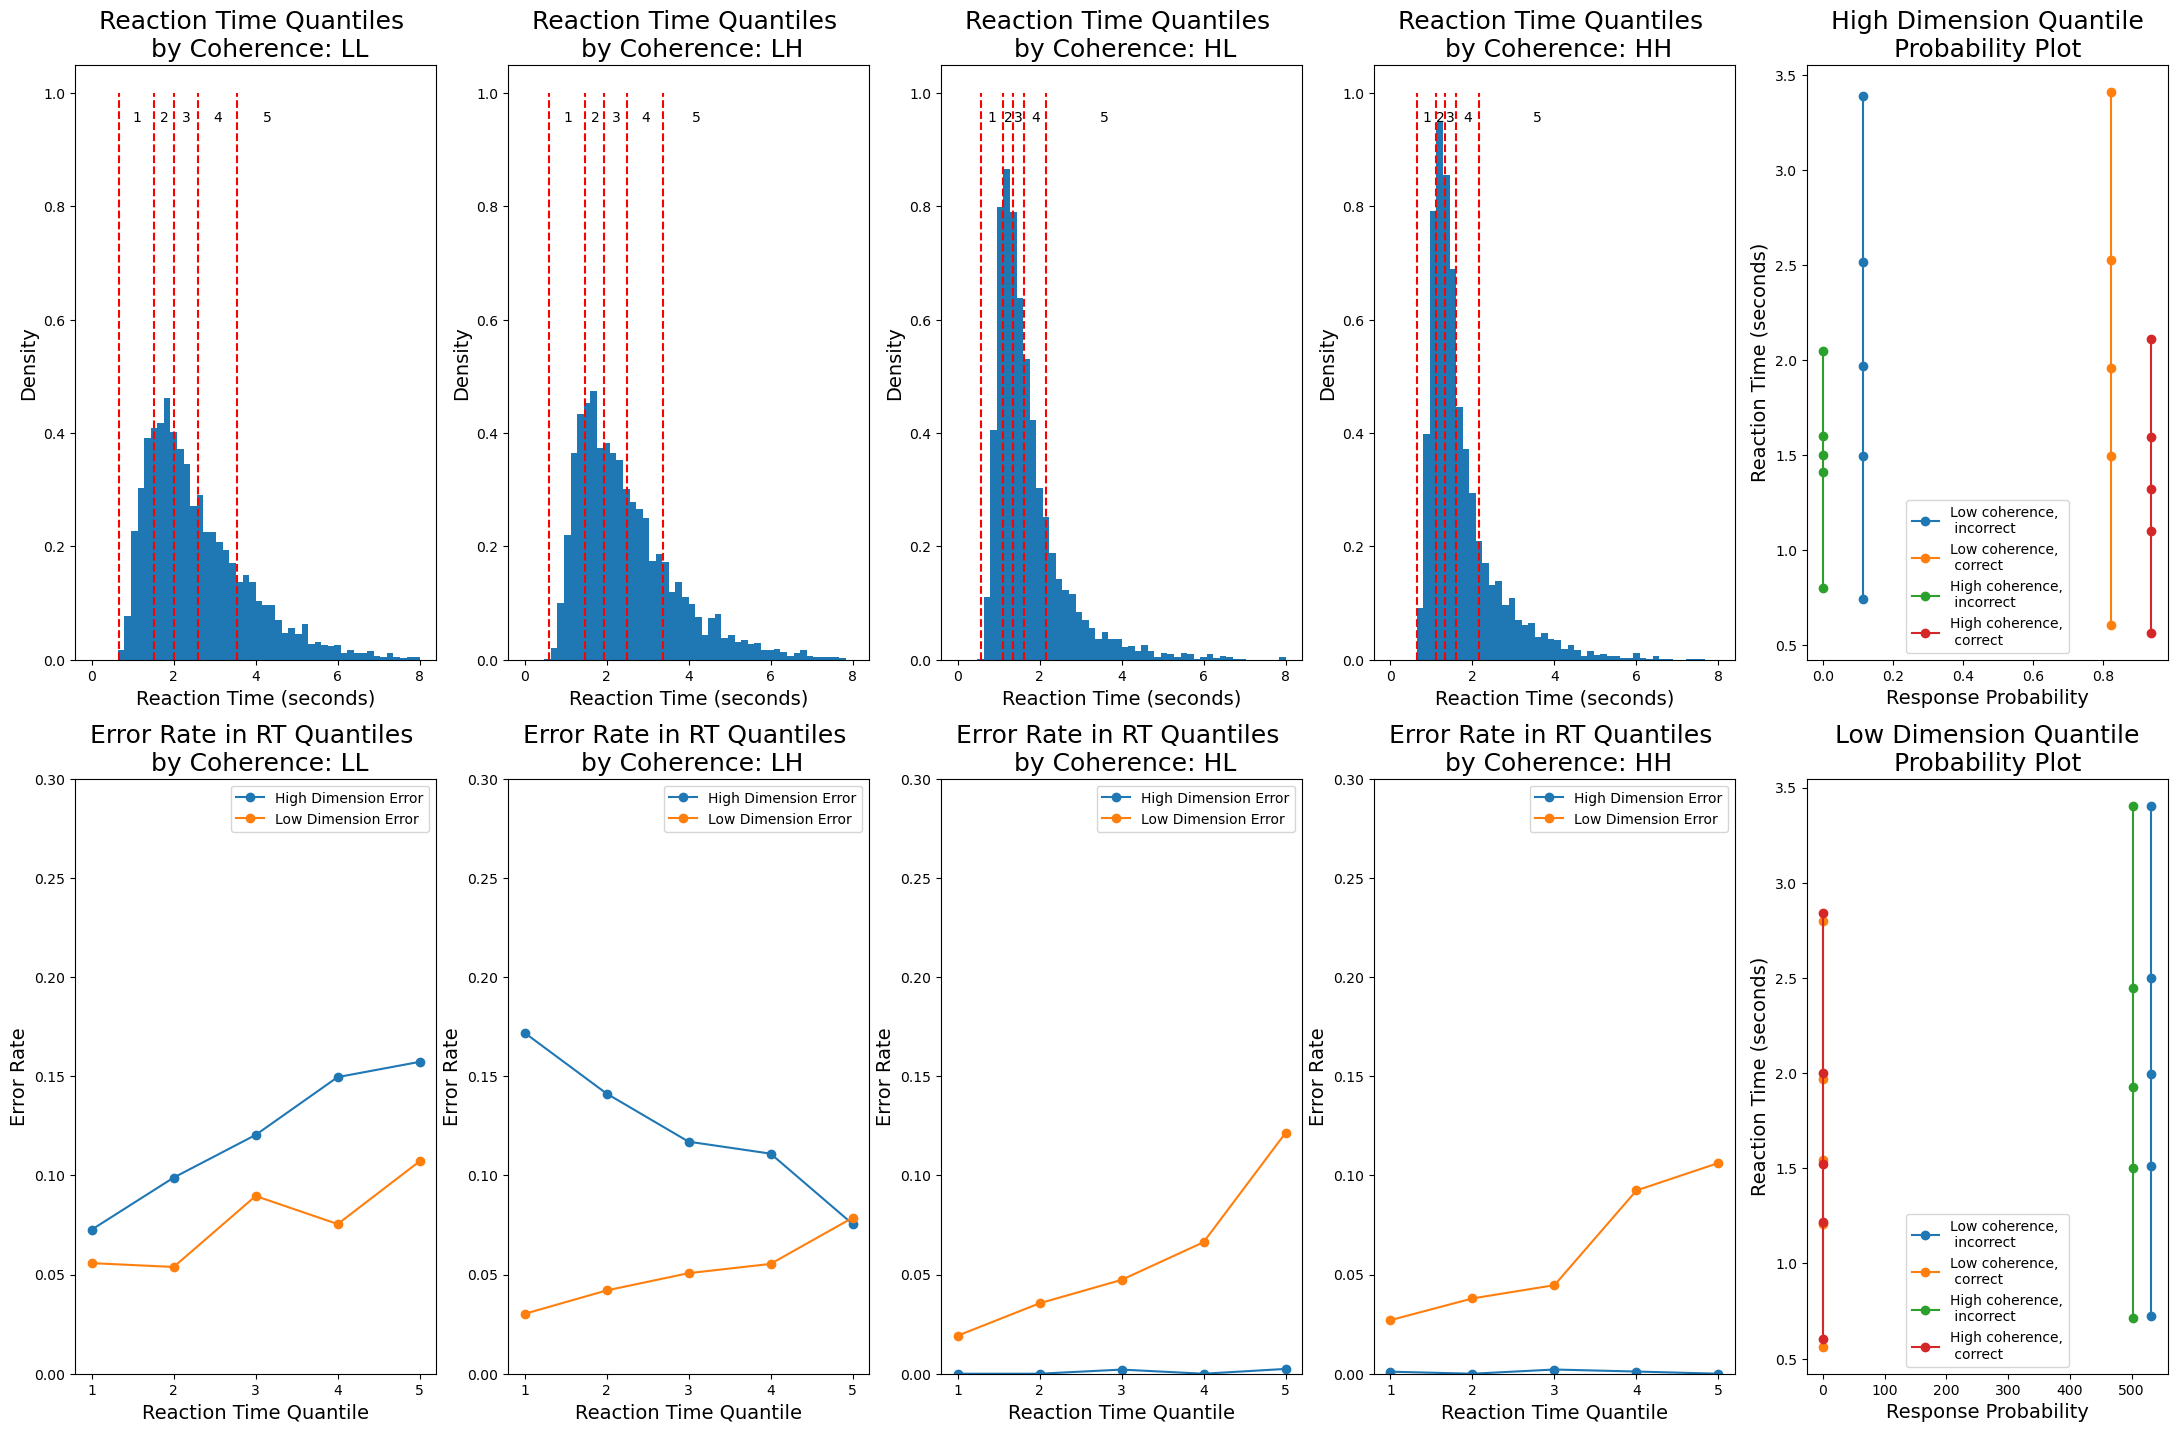

# Load observed and model data

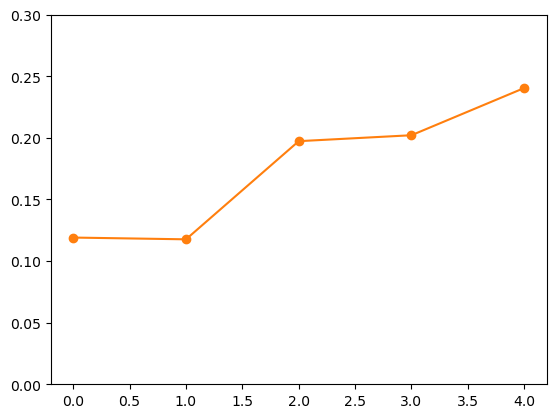

In [21]:
chong_data = data
err_plot(chong_data[(chong_data['highDimCoh']==-1) & (chong_data['lowDimCoh']==-1)],5)

In [8]:
rate_by_quantile(chong_data[(chong_data['highDimCoh']==-1)],1,5)


array([0.0021926 , 0.00399822, 0.00344163, 0.00279574, 0.00288513])

In [9]:
rate_by_quantile(chong_data[(chong_data['lowDimCoh']==-1)],1,5)


array([0.00113165, 0.        , 0.        , 0.00110053, 0.00462226])

In [3]:
chong_data['response'] = chong_data['response'] - 1
chong_data['response'] = chong_data['response'].mask((chong_data['isLowCorrect'] == 0) & (chong_data['isHighCorrect'] == 0), 0)
chong_data['response'] = chong_data['response'].mask((chong_data['isLowCorrect'] == 1) & (chong_data['isHighCorrect'] == 0), 1)
chong_data['response'] = chong_data['response'].mask((chong_data['isLowCorrect'] == 0) & (chong_data['isHighCorrect'] == 1), 2)
chong_data['response'] = chong_data['response'].mask((chong_data['isLowCorrect'] == 1) & (chong_data['isHighCorrect'] == 1), 3)

In [26]:
chong_data_no_13 = chong_data[chong_data['subj'] != 13]

In [27]:
chong_data_no_13 = chong_data_no_13.reset_index(drop = True)

In [29]:
np.unique(chong_data_no_13['response'] - observed_data['response'])

array([-3, -2, -1,  0,  1,  2,  3])

In [19]:
np.unique(chong_data_no_13['colorPer'] - observed_data['colorPer'])

array([0.])

In [18]:
observed_data

,anglePer,blockN,colorPer,correct,highDim,highDimCoh,irrDim,irrDimCoh,lineCoh,lineDir,angleOption,lowDim,lowDimCoh,response,rxtime,subj,isHighCorrect,isLowCorrect,lineOption
0,0.70,1,0.42,0,1,2,2,1,0.7,2,1,3,2,2,6.581300,1,1,0,2
1,0.30,1,0.42,0,1,2,2,1,0.7,2,2,3,2,2,6.581307,1,1,0,2
2,0.70,1,0.58,1,1,1,3,2,0.4,1,1,2,1,3,3.382378,1,1,1,1
3,0.30,1,0.42,1,1,1,2,1,0.6,2,2,3,2,3,2.999084,1,1,1,2
4,0.58,1,0.30,1,1,2,3,1,0.3,1,1,2,2,3,1.549884,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18416,0.30,4,0.70,1,3,2,2,2,0.4,1,2,1,1,3,4.422582,36,1,1,1
18417,0.30,4,0.42,1,3,2,2,1,0.6,2,2,1,1,3,3.873876,36,1,1,2
18418,0.42,4,0.58,1,3,1,2,1,0.6,2,2,1,1,3,1.496423,36,1,1,2
18419,0.58,4,0.58,0,3,1,1,1,0.6,2,1,2,1,1,0.665155,36,0,1,2


In [10]:
observed_data[observed_data['subj'] == 36]

,anglePer,blockN,colorPer,correct,highDim,highDimCoh,irrDim,irrDimCoh,lineCoh,lineDir,angleOption,lowDim,lowDimCoh,response,rxtime,subj,isHighCorrect,isLowCorrect,lineOption
17909,0.30,1,0.42,1,3,2,2,1,0.3,1,2,1,2,3,2.427239,36,1,1,1
17910,0.70,1,0.30,1,3,2,1,1,0.6,2,1,2,2,2,4.854550,36,1,1,2
17911,0.30,1,0.58,1,3,2,2,1,0.7,2,2,1,2,4,2.477334,36,1,1,2
17912,0.58,1,0.42,0,3,1,1,1,0.4,1,1,2,1,3,2.660211,36,0,1,1
17913,0.70,1,0.42,1,3,2,1,2,0.3,1,1,2,1,2,2.111768,36,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18416,0.30,4,0.70,1,3,2,2,2,0.4,1,2,1,1,3,4.422582,36,1,1,1
18417,0.30,4,0.42,1,3,2,2,1,0.6,2,2,1,1,4,3.873876,36,1,1,2
18418,0.42,4,0.58,1,3,1,2,1,0.6,2,2,1,1,4,1.496423,36,1,1,2
18419,0.58,4,0.58,0,3,1,1,1,0.6,2,1,2,1,4,0.665155,36,0,1,2


In [9]:
observed_data['response'] = observed_data['response'] - 1
observed_data['response'] = observed_data['response'].mask((observed_data['isLowCorrect'] == 0) & (observed_data['isHighCorrect'] == 0), 0)
observed_data['response'] = observed_data['response'].mask((observed_data['isLowCorrect'] == 1) & (observed_data['isHighCorrect'] == 0), 1)
observed_data['response'] = observed_data['response'].mask((observed_data['isLowCorrect'] == 0) & (observed_data['isHighCorrect'] == 1), 2)
observed_data['response'] = observed_data['response'].mask((observed_data['isLowCorrect'] == 1) & (observed_data['isHighCorrect'] == 1), 3)


In [3]:
observed_data.iloc[[6145]]

,anglePer,blockN,colorPer,correct,highDim,highDimCoh,irrDim,irrDimCoh,lineCoh,lineDir,angleOption,lowDim,lowDimCoh,response,rxtime,subj,isHighCorrect,isLowCorrect,lineOption
6145,0.3,1,0.42,0,1,1,2,1,0.4,1,2,3,2,1,1.645962,13,1,0,1


In [5]:
chong_orig[['stim']

0        13
1        13
2        12
3        13
4        12
         ..
18416    31
18417    31
18418    31
18419    32
18420    32
Name: stim, Length: 18421, dtype: int64

In [14]:
raw_data.iloc[faulty_array]

,anglePer,blockN,colorPer,correct,highDim,highDimCoh,irrDim,irrDimCoh,lineCoh,lineDir,angleOption,lowDim,lowDimCoh,response,rxtime,subj,isHighCorrect,isLowCorrect,lineOption
6143,0.58,1,0.42,0,1,1,3,1,0.6,2,1,2,1,3,5.669470,13,1,0,2
6145,0.30,1,0.42,0,1,1,2,1,0.4,1,2,3,2,1,1.645962,13,1,0,1
6149,0.58,1,0.42,0,1,1,2,1,0.4,1,1,3,1,2,7.714360,13,1,0,1
6158,0.42,1,0.30,0,1,2,2,2,0.3,1,2,3,1,1,3.159079,13,1,0,1
6160,0.42,1,0.58,0,1,2,3,1,0.7,2,2,2,1,4,3.325214,13,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18357,0.30,4,0.58,0,3,2,2,1,0.6,2,2,1,1,1,4.139915,36,0,1,2
18362,0.42,4,0.30,0,3,1,2,2,0.6,2,2,1,1,2,8.628732,36,0,1,2
18387,0.70,4,0.70,0,3,2,1,2,0.7,2,1,2,2,4,0.881291,36,0,1,2
18404,0.58,4,0.70,0,3,1,1,2,0.3,1,1,2,2,3,0.798217,36,0,1,1


In [16]:
raw_data.loc[raw_data['subj']== 1][['anglePer','colorPer','lineOption','highDim','irrDim','lowDim','response','isHighCorrect','isLowCorrect']]

,anglePer,colorPer,lineOption,highDim,irrDim,lowDim,response,isHighCorrect,isLowCorrect
0,0.70,0.42,2,1,2,3,4,1,0
1,0.30,0.42,2,1,2,3,3,1,0
2,0.70,0.58,1,1,3,2,1,1,1
3,0.30,0.42,2,1,2,3,4,1,1
4,0.58,0.30,1,1,3,2,2,1,1
...,...,...,...,...,...,...,...,...,...
507,0.30,0.30,2,1,2,3,4,1,1
508,0.30,0.30,2,1,2,3,4,1,1
509,0.70,0.42,1,1,3,2,1,1,0
510,0.42,0.30,1,1,3,2,2,1,1


In [15]:
raw_data.loc[raw_data['subj']== 15][['anglePer','colorPer','lineOption','highDim','irrDim','lowDim','response','isHighCorrect','isLowCorrect']]

,anglePer,colorPer,lineOption,highDim,irrDim,lowDim,response,isHighCorrect,isLowCorrect
7167,0.42,0.42,2,3,2,1,4,1,1
7168,0.30,0.58,1,3,2,1,1,0,1
7169,0.30,0.30,2,3,2,1,2,0,1
7170,0.70,0.42,1,3,1,2,3,0,1
7171,0.30,0.42,2,3,2,1,2,0,1
...,...,...,...,...,...,...,...,...,...
7673,0.30,0.70,1,3,2,1,3,1,1
7674,0.42,0.70,2,3,2,1,4,1,1
7675,0.30,0.42,1,3,2,1,3,1,1
7676,0.42,0.42,1,3,2,1,3,1,1


In [20]:
raw_diff = raw_data.iloc[faulty_array]
raw_diff_high_zero = raw_diff.loc[chong_diff['isHighCorrect'] == 0]
raw_diff_high_zero

,anglePer,blockN,colorPer,correct,highDim,highDimCoh,irrDim,irrDimCoh,lineCoh,lineDir,angleOption,lowDim,lowDimCoh,response,rxtime,subj,isHighCorrect,isLowCorrect,lineOption
6143,0.58,1,0.42,0,1,1,3,1,0.6,2,1,2,1,3,5.669470,13,1,0,2
6145,0.30,1,0.42,0,1,1,2,1,0.4,1,2,3,2,1,1.645962,13,1,0,1
6149,0.58,1,0.42,0,1,1,2,1,0.4,1,1,3,1,2,7.714360,13,1,0,1
6158,0.42,1,0.30,0,1,2,2,2,0.3,1,2,3,1,1,3.159079,13,1,0,1
6160,0.42,1,0.58,0,1,2,3,1,0.7,2,2,2,1,4,3.325214,13,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18332,0.58,4,0.42,0,3,1,1,2,0.7,2,1,2,1,4,1.064257,36,0,1,2
18339,0.70,4,0.58,0,3,2,1,1,0.6,2,1,2,1,4,0.848056,36,0,1,2
18340,0.70,4,0.30,0,3,2,1,2,0.3,1,1,2,2,3,0.931272,36,0,1,1
18356,0.58,4,0.30,0,3,1,1,1,0.4,1,1,2,2,3,1.812323,36,0,1,1


In [18]:
chong_diff = chong_orig.iloc[np.where((observed_data['response'] - chong_orig['response']) != 0)]
high_zero = chong_diff.loc[chong_diff['isHighCorrect'] == 0]
# high_zero.loc[high_zero['isLowCorrect'] == 0]

In [22]:
chong_orig

,anglePer,blockN,colorPer,correct,highDim,highDimCoh,irrDim,irrDimCoh,lineCoh,lineDir,...,lowDimCoh,response,rxtime,subj,isHighCorrect,isLowCorrect,lineOption,rt,stim,subj_idx
0,0.70,1,0.42,0,1,2,2,1,0.7,2,...,2,2,6.58130,1,1,0,2,6.58130,13,0
1,0.30,1,0.42,0,1,2,2,1,0.7,2,...,2,2,6.58130,1,1,0,2,6.58130,13,0
2,0.70,1,0.58,1,1,1,3,2,0.4,1,...,1,3,3.38240,1,1,1,1,3.38240,12,0
3,0.30,1,0.42,1,1,1,2,1,0.6,2,...,2,3,2.99910,1,1,1,2,2.99910,13,0
4,0.58,1,0.30,1,1,2,3,1,0.3,1,...,2,3,1.54990,1,1,1,1,1.54990,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18416,0.30,4,0.70,1,3,2,2,2,0.4,1,...,1,3,4.42260,37,1,1,1,4.42260,31,36
18417,0.30,4,0.42,1,3,2,2,1,0.6,2,...,1,3,3.87390,37,1,1,2,3.87390,31,36
18418,0.42,4,0.58,1,3,1,2,1,0.6,2,...,1,3,1.49640,37,1,1,2,1.49640,31,36
18419,0.58,4,0.58,0,3,1,1,1,0.6,2,...,1,1,0.66516,37,0,1,2,0.66516,32,36


In [11]:
observed_data.iloc[np.where((observed_data['response'] - chong_orig['response']) != 0)]

,anglePer,blockN,colorPer,correct,highDim,highDimCoh,irrDim,irrDimCoh,lineCoh,lineDir,angleOption,lowDim,lowDimCoh,response,rxtime,subj,isHighCorrect,isLowCorrect,lineOption
6143,0.58,1,0.42,0,1,1,3,1,0.6,2,1,2,1,2,5.669470,13,1,0,2
6145,0.30,1,0.42,0,1,1,2,1,0.4,1,2,3,2,2,1.645962,13,1,0,1
6149,0.58,1,0.42,0,1,1,2,1,0.4,1,1,3,1,2,7.714360,13,1,0,1
6158,0.42,1,0.30,0,1,2,2,2,0.3,1,2,3,1,2,3.159079,13,1,0,1
6160,0.42,1,0.58,0,1,2,3,1,0.7,2,2,2,1,2,3.325214,13,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18357,0.30,4,0.58,0,3,2,2,1,0.6,2,2,1,1,1,4.139915,36,0,1,2
18362,0.42,4,0.30,0,3,1,2,2,0.6,2,2,1,1,1,8.628732,36,0,1,2
18387,0.70,4,0.70,0,3,2,1,2,0.7,2,1,2,2,1,0.881291,36,0,1,2
18404,0.58,4,0.70,0,3,1,1,2,0.3,1,1,2,2,1,0.798217,36,0,1,1


In [78]:
observed_difference = observed_data.iloc[np.where((observed_data['response'] - chong_orig['response']) != 0)]
observed_difference.loc[observed_difference['response'] == 0]

,anglePer,blockN,colorPer,correct,highDim,highDimCoh,irrDim,irrDimCoh,lineCoh,lineDir,angleOption,lowDim,lowDimCoh,response,rxtime,subj,isHighCorrect,isLowCorrect,lineOption
6236,0.58,1,0.58,0,1,1,2,1,0.4,1,1,3,1,0,3.325268,13,0,0,1
6835,0.42,2,0.42,0,2,1,3,1,0.6,2,2,1,1,0,1.579578,14,0,0,2
6918,0.42,3,0.42,0,2,1,3,1,0.3,1,2,1,2,0,1.396792,14,0,0,1
7180,0.70,1,0.42,0,3,2,1,1,0.4,1,1,2,1,0,5.968678,15,0,0,1
7256,0.58,1,0.70,0,3,1,1,1,0.6,2,1,2,2,0,2.011680,15,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17620,0.30,2,0.42,0,2,1,3,2,0.4,1,2,1,1,0,4.638857,35,0,0,1
17650,0.58,2,0.42,0,2,1,3,1,0.7,2,1,1,2,0,1.912197,35,0,0,2
17754,0.58,3,0.42,0,2,1,3,1,0.4,1,1,1,1,0,2.959562,35,0,0,1
17812,0.58,4,0.30,0,2,2,3,1,0.4,1,1,1,1,0,2.427598,35,0,0,1


In [6]:

faulty_array = np.where((observed_data['response'] - chong_orig['response']) != 0)

In [30]:

faulty_array_chong = np.where((observed_data['response'] - chong_data_no_13['response']) != 0)

In [31]:
faulty_array_chong

(array([ 6143,  6145,  6146, ..., 18417, 18418, 18420]),)

In [14]:
faulty_array_chongorig = np.where((chong_data_no_13['response'] - chong_orig['response']) != 0)

In [15]:
faulty_array_chongorig

(array([], dtype=int64),)

In [32]:
faulty_array_chong

(array([ 6143,  6145,  6146, ..., 18417, 18418, 18420]),)

In [33]:
observed_data.iloc[faulty_array_chong]

,anglePer,blockN,colorPer,correct,highDim,highDimCoh,irrDim,irrDimCoh,lineCoh,lineDir,angleOption,lowDim,lowDimCoh,response,rxtime,subj,isHighCorrect,isLowCorrect,lineOption
6143,0.58,1,0.42,0,1,1,3,1,0.6,2,1,2,1,3,5.669470,13,1,0,2
6145,0.30,1,0.42,0,1,1,2,1,0.4,1,2,3,2,1,1.645962,13,1,0,1
6146,0.30,1,0.70,1,1,1,2,2,0.4,1,2,3,2,2,2.194568,13,1,1,1
6147,0.30,1,0.42,0,1,2,3,2,0.7,2,2,2,1,3,4.721848,13,1,0,2
6149,0.58,1,0.42,0,1,1,2,1,0.4,1,1,3,1,2,7.714360,13,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18415,0.42,4,0.30,0,3,1,2,2,0.6,2,2,1,1,3,0.814713,36,1,0,2
18416,0.30,4,0.70,1,3,2,2,2,0.4,1,2,1,1,3,4.422582,36,1,1,1
18417,0.30,4,0.42,1,3,2,2,1,0.6,2,2,1,1,4,3.873876,36,1,1,2
18418,0.42,4,0.58,1,3,1,2,1,0.6,2,2,1,1,4,1.496423,36,1,1,2


In [34]:
chong_data_no_13.iloc[faulty_array_chong]

,anglePer,blockN,colorPer,correct,highDim,highDimCoh,irrDim,irrDimCoh,lineCoh,lineDir,angleOption,lowDim,lowDimCoh,response,rxtime,subj,isHighCorrect,isLowCorrect,lineOption,Unnamed: 19
6143,0.58,1,0.42,0,1,1,3,1,0.6,2,1,2,1,1,5.66950,14,0,1,2,NaN
6145,0.30,1,0.42,0,1,1,2,1,0.4,1,2,3,2,4,1.64600,14,0,1,1,NaN
6146,0.30,1,0.70,1,1,1,2,2,0.4,1,2,3,2,3,2.19460,14,1,1,1,NaN
6147,0.30,1,0.42,0,1,2,3,2,0.7,2,2,2,1,4,4.72180,14,1,0,2,NaN
6149,0.58,1,0.42,0,1,1,2,1,0.4,1,1,3,1,3,7.71440,14,0,0,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18415,0.42,4,0.30,0,3,1,2,2,0.6,2,2,1,1,4,0.81471,37,1,0,2,NaN
18416,0.30,4,0.70,1,3,2,2,2,0.4,1,2,1,1,2,4.42260,37,1,1,1,NaN
18417,0.30,4,0.42,1,3,2,2,1,0.6,2,2,1,1,2,3.87390,37,1,1,2,NaN
18418,0.42,4,0.58,1,3,1,2,1,0.6,2,2,1,1,1,1.49640,37,1,1,2,NaN


In [17]:
observed_data

,anglePer,blockN,colorPer,correct,highDim,highDimCoh,irrDim,irrDimCoh,lineCoh,lineDir,angleOption,lowDim,lowDimCoh,response,rxtime,subj,isHighCorrect,isLowCorrect,lineOption
0,0.70,1,0.42,0,1,2,2,1,0.7,2,1,3,2,2,6.581300,1,1,0,2
1,0.30,1,0.42,0,1,2,2,1,0.7,2,2,3,2,2,6.581307,1,1,0,2
2,0.70,1,0.58,1,1,1,3,2,0.4,1,1,2,1,3,3.382378,1,1,1,1
3,0.30,1,0.42,1,1,1,2,1,0.6,2,2,3,2,3,2.999084,1,1,1,2
4,0.58,1,0.30,1,1,2,3,1,0.3,1,1,2,2,3,1.549884,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18416,0.30,4,0.70,1,3,2,2,2,0.4,1,2,1,1,3,4.422582,36,1,1,1
18417,0.30,4,0.42,1,3,2,2,1,0.6,2,2,1,1,3,3.873876,36,1,1,2
18418,0.42,4,0.58,1,3,1,2,1,0.6,2,2,1,1,3,1.496423,36,1,1,2
18419,0.58,4,0.58,0,3,1,1,1,0.6,2,1,2,1,1,0.665155,36,0,1,2


In [16]:
chong_data_no_13

,anglePer,blockN,colorPer,correct,highDim,highDimCoh,irrDim,irrDimCoh,lineCoh,lineDir,angleOption,lowDim,lowDimCoh,response,rxtime,subj,isHighCorrect,isLowCorrect,lineOption
0,0.70,1.0,0.42,0.0,1.0,2.0,2.0,1.0,0.7,2.0,1.0,3.0,2.0,2.0,6.5813,1.0,1.0,0.0,2.0
1,0.30,1.0,0.42,0.0,1.0,2.0,2.0,1.0,0.7,2.0,2.0,3.0,2.0,2.0,6.5813,1.0,1.0,0.0,2.0
2,0.70,1.0,0.58,1.0,1.0,1.0,3.0,2.0,0.4,1.0,1.0,2.0,1.0,3.0,3.3824,1.0,1.0,1.0,1.0
3,0.30,1.0,0.42,1.0,1.0,1.0,2.0,1.0,0.6,2.0,2.0,3.0,2.0,3.0,2.9991,1.0,1.0,1.0,2.0
4,0.58,1.0,0.30,1.0,1.0,2.0,3.0,1.0,0.3,1.0,1.0,2.0,2.0,3.0,1.5499,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18416,0.70,1.0,0.30,1.0,3.0,2.0,1.0,1.0,0.6,2.0,1.0,2.0,2.0,3.0,1.5296,37.0,1.0,1.0,2.0
18417,0.42,1.0,0.30,0.0,3.0,1.0,2.0,2.0,0.7,2.0,2.0,1.0,2.0,2.0,3.6410,37.0,1.0,0.0,2.0
18418,0.70,1.0,0.70,1.0,3.0,2.0,1.0,1.0,0.4,1.0,1.0,2.0,2.0,3.0,6.0851,37.0,1.0,1.0,1.0
18419,0.70,1.0,0.42,1.0,3.0,2.0,1.0,2.0,0.7,2.0,1.0,2.0,1.0,3.0,2.0616,37.0,1.0,1.0,2.0


In [20]:
chong_data_no_13.drop(1)

,anglePer,blockN,colorPer,correct,highDim,highDimCoh,irrDim,irrDimCoh,lineCoh,lineDir,angleOption,lowDim,lowDimCoh,response,rxtime,subj,isHighCorrect,isLowCorrect,lineOption,Unnamed: 19
0,0.70,1,0.42,0,1,2,2,1,0.7,2,1,3,2,2,6.58130,1,1,0,2,NaN
2,0.70,1,0.58,1,1,1,3,2,0.4,1,1,2,1,3,3.38240,1,1,1,1,NaN
3,0.30,1,0.42,1,1,1,2,1,0.6,2,2,3,2,3,2.99910,1,1,1,2,NaN
4,0.58,1,0.30,1,1,2,3,1,0.3,1,1,2,2,3,1.54990,1,1,1,1,NaN
5,0.70,1,0.58,1,1,1,3,2,0.4,1,1,2,1,3,2.31600,1,1,1,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18852,0.30,4,0.70,1,3,2,2,2,0.4,1,2,1,1,3,4.42260,37,1,1,1,NaN
18853,0.30,4,0.42,1,3,2,2,1,0.6,2,2,1,1,3,3.87390,37,1,1,2,NaN
18854,0.42,4,0.58,1,3,1,2,1,0.6,2,2,1,1,3,1.49640,37,1,1,2,NaN
18855,0.58,4,0.58,0,3,1,1,1,0.6,2,1,2,1,1,0.66516,37,0,1,2,NaN


In [10]:
faulty_array_chong

(array([ 6143,  6144,  6145, ..., 18854, 18855, 18856]),)

In [13]:
chong_data_no_13.iloc[faulty_array_chong]

IndexError: positional indexers are out-of-bounds

In [7]:
faulty_array

(array([ 6143,  6145,  6147, ..., 18854, 18855, 18856]),)

In [40]:
raw_diff[raw_diff['subj'] == 13][:12]

,anglePer,blockN,colorPer,correct,highDim,highDimCoh,irrDim,irrDimCoh,lineCoh,lineDir,angleOption,lowDim,lowDimCoh,response,rxtime,subj,isHighCorrect,isLowCorrect,lineOption
6143,0.58,1,0.42,0,1,1,3,1,0.6,2,1,2,1,3,5.669470,13,1,0,2
6145,0.30,1,0.42,0,1,1,2,1,0.4,1,2,3,2,1,1.645962,13,1,0,1
6149,0.58,1,0.42,0,1,1,2,1,0.4,1,1,3,1,2,7.714360,13,1,0,1
6158,0.42,1,0.30,0,1,2,2,2,0.3,1,2,3,1,1,3.159079,13,1,0,1
6160,0.42,1,0.58,0,1,2,3,1,0.7,2,2,2,1,4,3.325214,13,1,0,2
6162,0.58,1,0.58,0,1,1,3,1,0.6,2,1,2,1,4,5.104371,13,1,0,2
6184,0.30,1,0.42,0,1,1,3,2,0.6,2,2,2,1,2,1.346822,13,0,1,2
6186,0.30,1,0.70,0,1,1,2,2,0.4,1,2,3,2,3,7.265674,13,0,1,1
6236,0.58,1,0.58,0,1,1,2,1,0.4,1,1,3,1,4,3.325268,13,0,0,1
6239,0.58,1,0.42,0,1,2,3,1,0.7,2,1,2,1,3,2.377477,13,1,0,2


In [41]:
chong_diff[chong_diff['subj_idx'] == 13][:12]

,anglePer,blockN,colorPer,correct,highDim,highDimCoh,irrDim,irrDimCoh,lineCoh,lineDir,...,lowDimCoh,response,rxtime,subj,isHighCorrect,isLowCorrect,lineOption,rt,stim,subj_idx
6143,0.58,1,0.42,0,1,1,3,1,0.6,2,...,1,1,5.6695,14,0,1,2,5.6695,12,13
6145,0.30,1,0.42,0,1,1,2,1,0.4,1,...,2,1,1.6460,14,0,1,1,1.6460,13,13
6149,0.58,1,0.42,0,1,1,2,1,0.4,1,...,1,0,7.7144,14,0,0,1,7.7144,13,13
6158,0.42,1,0.30,0,1,2,2,2,0.3,1,...,1,1,3.1591,14,0,1,1,3.1591,13,13
6160,0.42,1,0.58,0,1,2,3,1,0.7,2,...,1,1,3.3252,14,0,1,2,3.3252,12,13
6162,0.58,1,0.58,0,1,1,3,1,0.6,2,...,1,1,5.1044,14,0,1,2,5.1044,12,13
6184,0.30,1,0.42,0,1,1,3,2,0.6,2,...,1,2,1.3468,14,1,0,2,1.3468,12,13
6186,0.30,1,0.70,0,1,1,2,2,0.4,1,...,2,2,7.2657,14,1,0,1,7.2657,13,13
6236,0.58,1,0.58,0,1,1,2,1,0.4,1,...,1,1,3.3253,14,0,1,1,3.3253,13,13
6239,0.58,1,0.42,0,1,2,3,1,0.7,2,...,1,1,2.3775,14,0,1,2,2.3775,12,13


In [90]:
chong_orig['response']

0        2
1        2
2        3
3        3
4        3
        ..
18416    3
18417    3
18418    3
18419    1
18420    3
Name: response, Length: 18421, dtype: int64

In [83]:
chong_orig['response']

0        2
1        2
2        3
3        3
4        3
        ..
18416    3
18417    3
18418    3
18419    1
18420    3
Name: response, Length: 18421, dtype: int64

In [91]:
np.unique(np.array(observed_data['lowDimCoh'].tolist()) - np.array(chong_orig['lowDimCoh'].tolist()))

array([0])

In [21]:
def rolling_window(a, size):
    shape = a.shape[:-1] + (a.shape[-1] - size + 1, size)
    strides = a.strides + (a. strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [32]:
np.unique(np.all((rolling_window(np.array(chong_orig.response), 6) == [3,2,0,3,1,0]),axis = 1))

array([False])

In [35]:
np.unique(np.all((rolling_window(np.array(observed_data.response), 9) == [2,2,3,3,3,3,1,3,2]),axis = 1))

array([False])

In [5]:
my_columns = [c for c in chong_orig if c in observed_data.columns]

In [15]:
np.unique(np.array(chong_orig['highDimCoh']) - np.array(observed_data['highDimCoh']))

array([0])

In [18]:
np.array(chong_orig.response) - np.array(observed_data.response)

array([-2, -1,  2, ..., -1, -3,  2])

In [17]:
observed_data.response

0        4
1        3
2        1
3        4
4        2
        ..
18416    3
18417    4
18418    4
18419    4
18420    1
Name: response, Length: 18421, dtype: int64

In [12]:
chong_orig[chong_orig.highDimCoh == 2].response 

0        2
1        2
4        3
7        3
8        2
        ..
18848    3
18849    3
18850    3
18852    3
18853    3
Name: response, Length: 9212, dtype: int64

In [13]:
observed_data[observed_data.highDimCoh == 2].response

0        3
1        2
4        1
7        2
8        3
        ..
18412    3
18413    0
18414    0
18416    2
18417    3
Name: response, Length: 9212, dtype: int64

In [8]:
observed_data[observed_data.highDimCoh == 2].response

array([0, 1, 2, 3])

In [6]:
[c for c in observed_data if c in chong_orig.columns]

[]

In [7]:
observed_data.columns

Index(['anglePer', 'blockN', 'colorPer', 'correct', 'highDim', 'highDimCoh',
       'irrDim', 'irrDimCoh', 'lineCoh', 'lineDir', 'angleOption', 'lowDim',
       'lowDimCoh', 'response', 'rxtime', 'subj', 'isHighCorrect',
       'isLowCorrect', 'lineOption'],
      dtype='object')

In [8]:
np.unique(np.array(observed_data['blockN']) - np.array(chong_orig['blockN']))

array([0])

In [1]:
plt.figure(figsize=(27,17))
all_plots(chong_orig)
plt.suptitle('Observed Data Quantile Plots', fontsize=24)


NameError: name 'plt' is not defined

In [24]:
plt.figure(figsize=(27,17))
all_plots(observed_data)
plt.suptitle('Observed Data Plot Bank', fontsize=24)

NameError: name 'observed_data' is not defined

<Figure size 2700x1700 with 0 Axes>

In [9]:
chong_orig

,anglePer,blockN,colorPer,correct,highDim,highDimCoh,irrDim,irrDimCoh,lineCoh,lineDir,...,subj,isHighCorrect,isLowCorrect,lineOption,Unnamed: 19,rt,stim,subj_idx,cond,cond2
0,0.70,1,0.42,0,1,2,2,1,0.7,2,...,1,1,0,2,NaN,6.58130,13,0,212,22
1,0.30,1,0.42,0,1,2,2,1,0.7,2,...,1,1,0,2,NaN,6.58130,13,0,212,22
2,0.70,1,0.58,1,1,1,3,2,0.4,1,...,1,1,1,1,NaN,3.38240,12,0,121,11
3,0.30,1,0.42,1,1,1,2,1,0.6,2,...,1,1,1,2,NaN,2.99910,13,0,112,12
4,0.58,1,0.30,1,1,2,3,1,0.3,1,...,1,1,1,1,NaN,1.54990,12,0,212,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18852,0.30,4,0.70,1,3,2,2,2,0.4,1,...,37,1,1,1,NaN,4.42260,31,36,221,21
18853,0.30,4,0.42,1,3,2,2,1,0.6,2,...,37,1,1,2,NaN,3.87390,31,36,211,21
18854,0.42,4,0.58,1,3,1,2,1,0.6,2,...,37,1,1,2,NaN,1.49640,31,36,111,11
18855,0.58,4,0.58,0,3,1,1,1,0.6,2,...,37,0,1,2,NaN,0.66516,32,36,111,11


In [18]:
observed_data

,anglePer,blockN,colorPer,correct,highDim,highDimCoh,irrDim,irrDimCoh,lineCoh,lineDir,angleOption,lowDim,lowDimCoh,response,rxtime,subj,isHighCorrect,isLowCorrect,lineOption
0,0.70,1,0.42,0,1,2,2,1,0.7,2,1,3,2,4,6.581300,1,1,0,2
1,0.30,1,0.42,0,1,2,2,1,0.7,2,2,3,2,3,6.581307,1,1,0,2
2,0.70,1,0.58,1,1,1,3,2,0.4,1,1,2,1,1,3.382378,1,1,1,1
3,0.30,1,0.42,1,1,1,2,1,0.6,2,2,3,2,4,2.999084,1,1,1,2
4,0.58,1,0.30,1,1,2,3,1,0.3,1,1,2,2,2,1.549884,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18416,0.30,4,0.70,1,3,2,2,2,0.4,1,2,1,1,3,4.422582,36,1,1,1
18417,0.30,4,0.42,1,3,2,2,1,0.6,2,2,1,1,4,3.873876,36,1,1,2
18418,0.42,4,0.58,1,3,1,2,1,0.6,2,2,1,1,4,1.496423,36,1,1,2
18419,0.58,4,0.58,0,3,1,1,1,0.6,2,1,2,1,4,0.665155,36,0,1,2


In [6]:
sequential = load_posterior_predictive("ddm_seq2_no_bias",0,1,0)
parallel = load_posterior_predictive("ddm_par2_no_bias")
tradeoff = load_posterior_predictive("ddm_mic2_adj_no_bias",1,1,1)

FileNotFoundError: [Errno 2] No such file or directory: 'data/posterior_predictives/ddm_seq2_no_bias'

# Create plot bank

In [3]:
plt.figure(figsize=(27,17))
all_plots(observed_data)
plt.suptitle('Observed Data Plot Bank', fontsize=24)

NameError: name 'observed_data' is not defined

<Figure size 2700x1700 with 0 Axes>

In [1]:
plt.figure(figsize=(27,17))
all_plots(parallel)
plt.suptitle('Parallel Model Posterior Predictive Plot Bank', fontsize=24)

NameError: name 'plt' is not defined

Text(0.5, 0.98, 'Tradeoff Model Posterior Predictive Plot Bank')

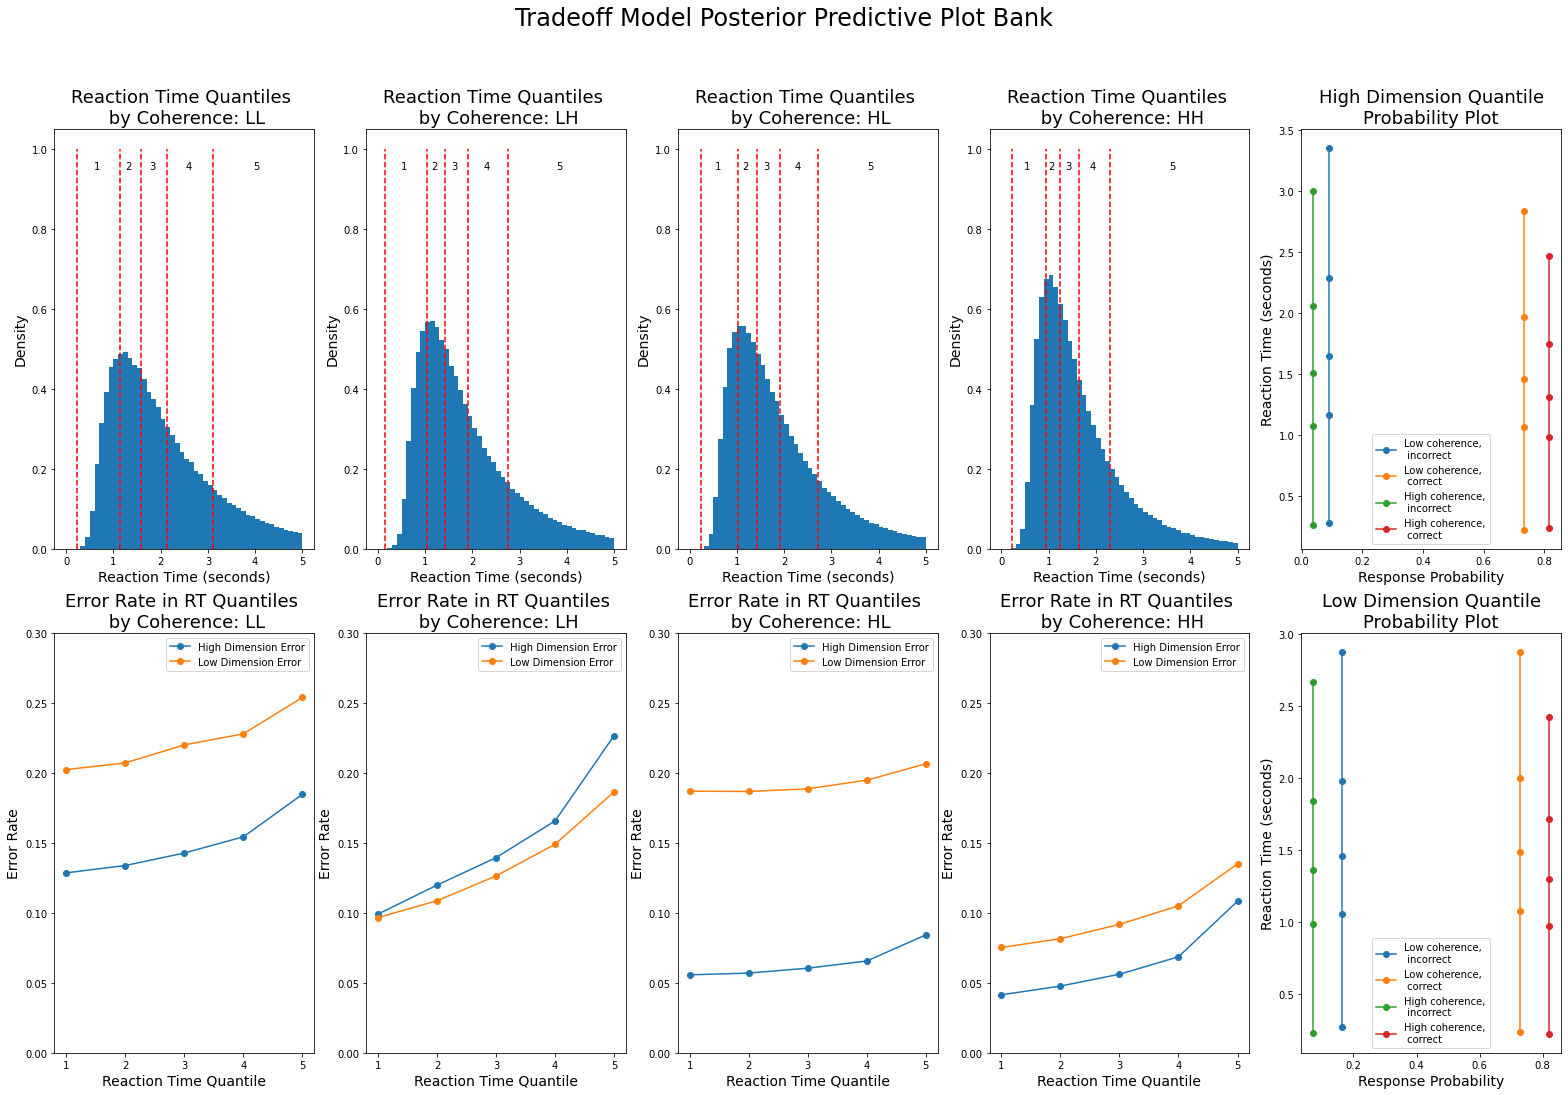

In [6]:
plt.figure(figsize=(27,17))
all_plots(tradeoff)
plt.suptitle('Tradeoff Model Posterior Predictive Plot Bank', fontsize=24)

Text(0.5, 0.98, 'Sequential Model Posterior Predictive Plot Bank')

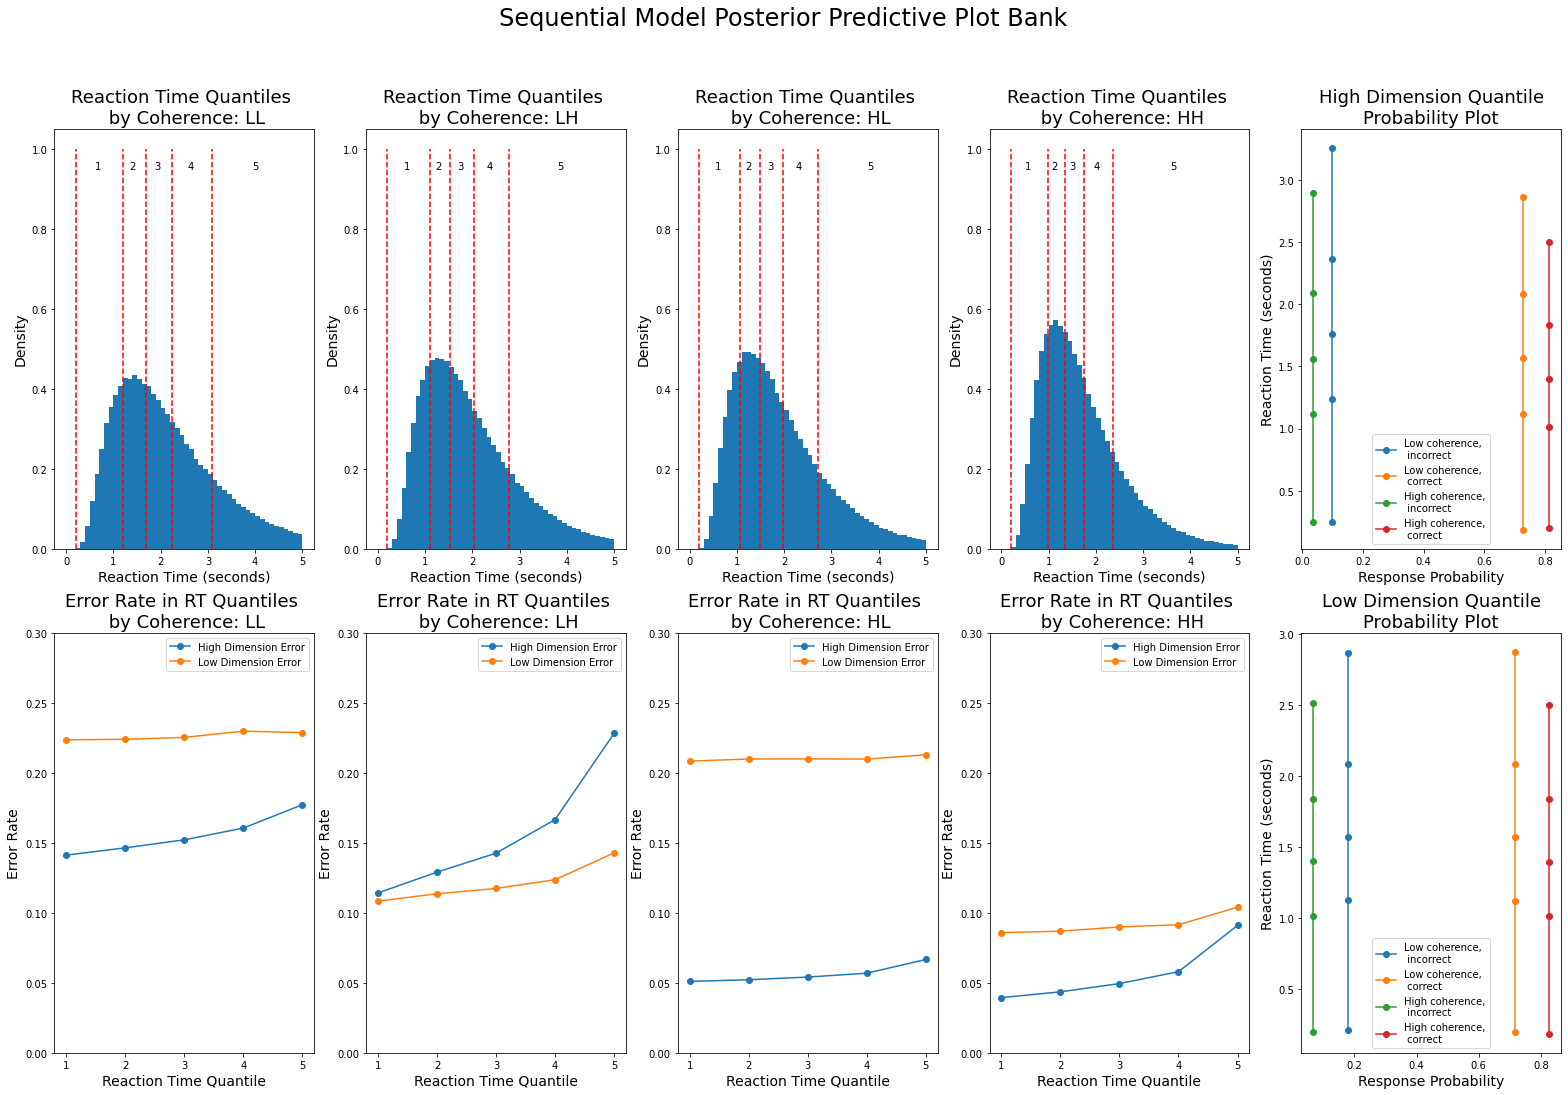

In [8]:
plt.figure(figsize=(27,17))
all_plots(sequential)
plt.suptitle('Sequential Model Posterior Predictive Plot Bank', fontsize=24)